In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb

In [2]:
train_data = pd.read_csv('train.csv', index_col='PassengerId')
test_data = pd.read_csv('test.csv', index_col='PassengerId')
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


# 1. EDA

# 1.1. Overview

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


# 1.2. Missing values

# Train data

In [5]:
all_features_train = train_data.columns.to_list()
nan_values_train = {}

for feature in all_features_train:
    num_nan_values = train_data[feature].isna().sum()
    nan_values_train[feature] = num_nan_values

print(nan_values_train)

{'Survived': 0, 'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 0, 'Cabin': 687, 'Embarked': 2}


1.2.1. Age

In [6]:
# filling out 'Age' NaNs with median values based on Pclass and Sex
median_age = train_data.groupby(['Pclass', 'Sex'])['Age'].median()

for pclass in range(1,4):
    for sex in ['female', 'male']:
        print(f"Median age of Pclass {pclass} {sex}: {median_age[pclass, sex]}")

train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

Median age of Pclass 1 female: 35.0
Median age of Pclass 1 male: 40.0
Median age of Pclass 2 female: 28.0
Median age of Pclass 2 male: 30.0
Median age of Pclass 3 female: 21.5
Median age of Pclass 3 male: 25.0


1.2.2. Embarked

In [7]:
# filling out 'Embarked' NaNs with most common value
train_data['Embarked'] = train_data['Embarked'].fillna('S')

1.2.3. Cabin

In [8]:
# removing feature 'Cabin'
train_data = train_data.drop(columns=['Cabin'])

# Test data

In [9]:
all_features_test = test_data.columns.to_list()
nan_values_test = {}

for feature in all_features_test:
    num_nan_values = test_data[feature].isna().sum()
    nan_values_test[feature] = num_nan_values

print(nan_values_test)

{'Pclass': 0, 'Name': 0, 'Sex': 0, 'Age': 86, 'SibSp': 0, 'Parch': 0, 'Ticket': 0, 'Fare': 1, 'Cabin': 327, 'Embarked': 0}


1.2.1. Age

In [10]:
# filling out 'Age' NaNs with median train values based on Pclass and Sex
test_data['Age'] = test_data.apply(lambda row: median_age[row['Pclass'], row['Sex']] if pd.isnull(row['Age']) else row['Age'], axis=1)

1.2.2. Fare

In [11]:
test_data[test_data['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [12]:
# filling out 'Fare' NaN with median value based on Pclass and Sex for this person
median_fare = train_data.groupby(['Pclass', 'Sex'])['Fare'].median()[3, 'male']
test_data['Fare'] = test_data['Fare'].fillna(median_fare)

1.2.3. Cabin

In [13]:
# removing feature 'Cabin'
test_data = test_data.drop(columns=['Cabin'])

# 1.3. Some graphs in order to understand the data

* Numerical feature distributions

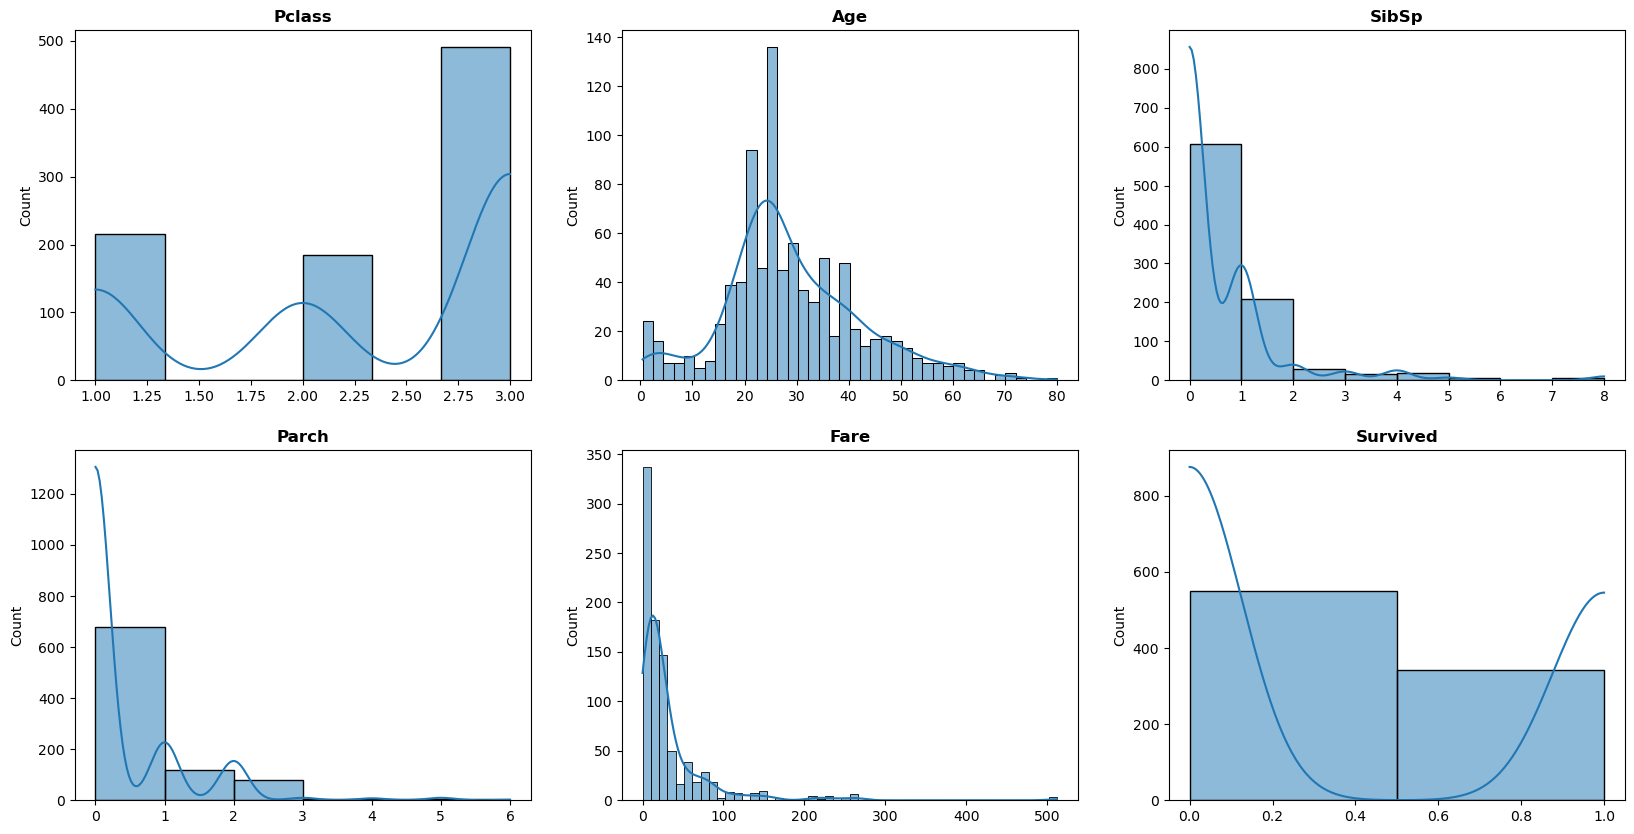

In [14]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.histplot(train_data['Pclass'], bins=6, kde=True, ax=axis[0,0])
axis[0,0].set_title('Pclass', fontweight='bold')
axis[0,0].set_xlabel('')

sns.histplot(train_data['Age'], bins=40, kde=True, ax=axis[0,1])
axis[0,1].set_title('Age', fontweight='bold')
axis[0,1].set_xlabel('')

sns.histplot(train_data['SibSp'], bins=8, kde=True, ax=axis[0,2])
axis[0,2].set_title('SibSp', fontweight='bold')
axis[0,2].set_xlabel('')

sns.histplot(train_data['Parch'], bins=6, kde=True, ax=axis[1,0])
axis[1,0].set_title('Parch', fontweight='bold')
axis[1,0].set_xlabel('')

sns.histplot(train_data['Fare'], bins=50, kde=True, ax=axis[1,1])
axis[1,1].set_title('Fare', fontweight='bold')
axis[1,1].set_xlabel('')

sns.histplot(train_data['Survived'], bins=2, kde=True, ax=axis[1,2])
axis[1,2].set_title('Survived', fontweight='bold')
axis[1,2].set_xlabel('')

plt.show()

* Categorical features

In [15]:
unique_values = {}
categorical_features = ['Name', 'Sex', 'Ticket', 'Embarked']

for cat_feature in categorical_features:
    unique_n = train_data[cat_feature].nunique()
    unique_values[cat_feature] = unique_n

print(unique_values)

{'Name': 891, 'Sex': 2, 'Ticket': 681, 'Embarked': 3}


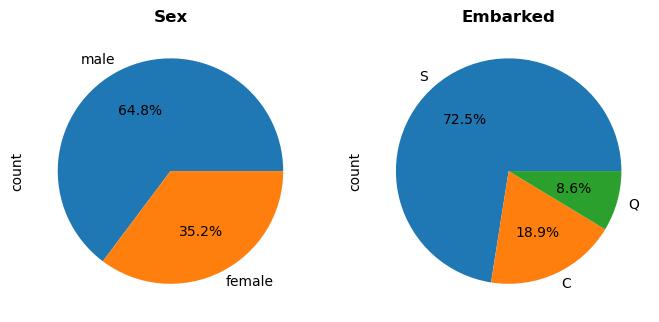

In [16]:
_, axis = plt.subplots(ncols=2, figsize=(8,4))
train_data['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[0])
axis[0].set_title('Sex', fontweight='bold')

train_data['Embarked'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[1])
axis[1].set_title('Embarked', fontweight='bold')
plt.show()

Some correlation between features and target

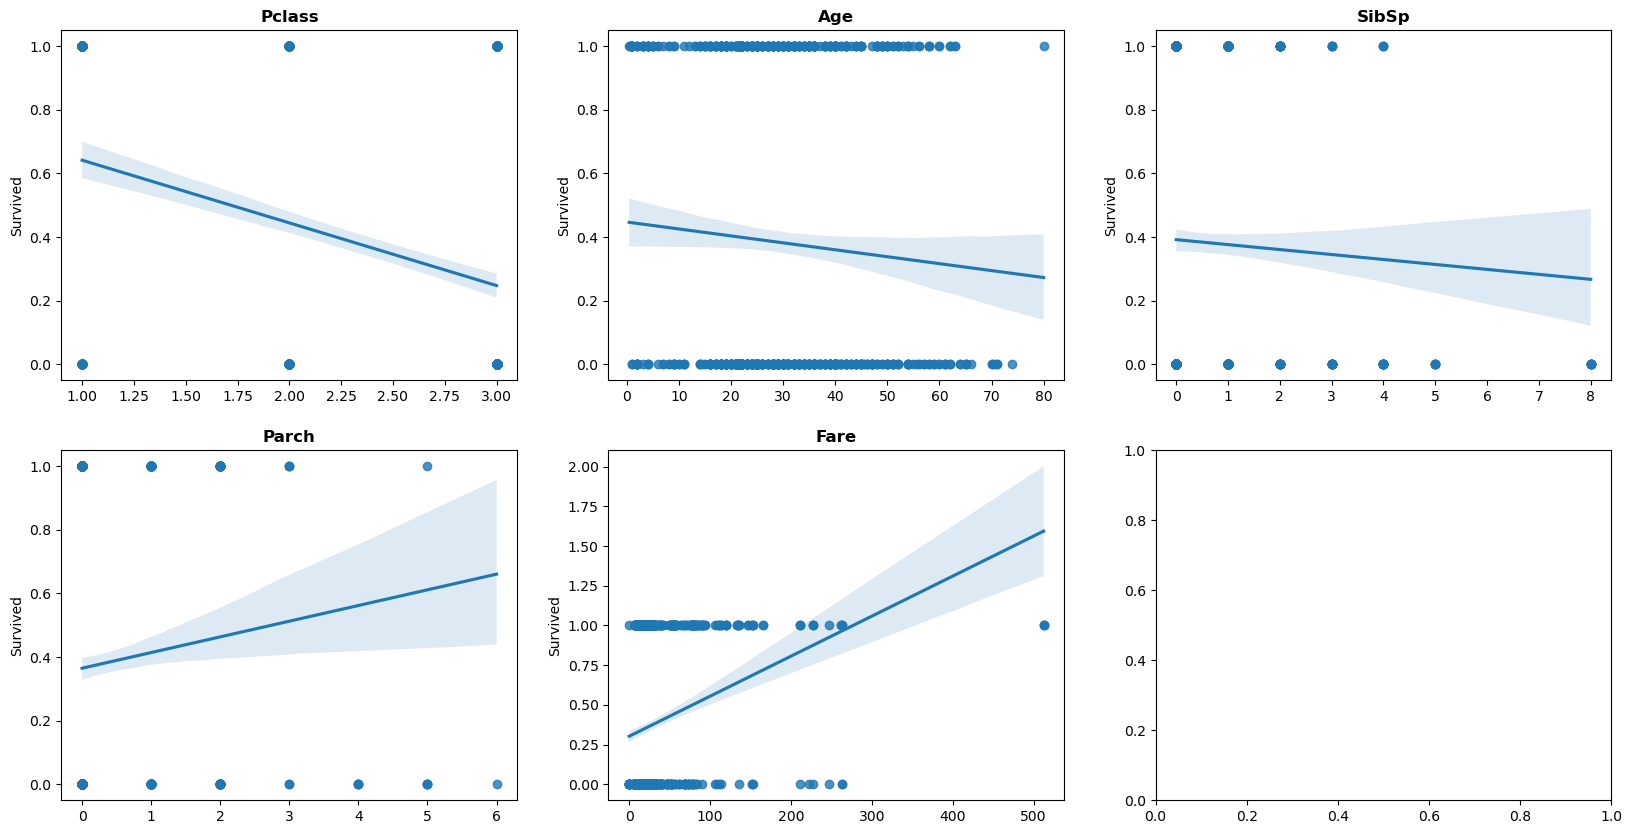

In [17]:
_, axis = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.regplot(data=train_data, x='Pclass', y='Survived', ax=axis[0,0])
axis[0,0].set_title('Pclass', fontweight='bold')
axis[0,0].set_xlabel('')

sns.regplot(data=train_data, x='Age', y='Survived', ax=axis[0,1])
axis[0,1].set_title('Age', fontweight='bold')
axis[0,1].set_xlabel('')

sns.regplot(data=train_data, x='SibSp', y='Survived', ax=axis[0,2])
axis[0,2].set_title('SibSp', fontweight='bold')
axis[0,2].set_xlabel('')

sns.regplot(data=train_data, x='Parch', y='Survived', ax=axis[1,0])
axis[1,0].set_title('Parch', fontweight='bold')
axis[1,0].set_xlabel('')

sns.regplot(data=train_data, x='Fare', y='Survived', ax=axis[1,1])
axis[1,1].set_title('Fare', fontweight='bold')
axis[1,1].set_xlabel('')

plt.show()

Deleting some features

In [18]:
train_data = train_data.drop(columns=['Name', 'Ticket'])
test_data = test_data.drop(columns=['Name', 'Ticket'])

# 3. Data engineering

* Adding feature 'Family members'

In [19]:
train_data['Family_members'] = train_data['SibSp'] + train_data['Parch']
test_data['Family_members'] = test_data['SibSp'] + test_data['Parch']

* Adding feature 'Fare_range' based on percentilies

In [20]:
train_data['Fare'].describe(percentiles=[.25, .5, .75])

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [21]:
train_data['Fare_range'] = pd.cut(train_data['Fare'],
                                  bins=[0, 7.91, 14.45, 31, float('inf')],
                                  labels=['Cheap', 'Middle', 'Expensive', 'Very expensive'])

test_data['Fare_range'] = pd.cut(test_data['Fare'],
                                  bins=[0, 7.91, 14.45, 31, float('inf')],
                                  labels=['Cheap', 'Middle', 'Expensive', 'Very expensive'])

# 4. Encoding categorical features

# 5. Splitting data into train, val and test 

In [22]:
X_data = train_data.drop(columns=['Survived'])
y_data = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=26)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 9), (179, 9), (712,), (179,))

In [23]:
X_test = test_data

# 6. Scaling features

# 7. Modeling 